# Using XGBoost Model for longawave estimation of cloud fraction



Objectif : estimate cloud fraction using Temperature, Relative Humidity, Pressure, Gblobal Shortwave, Diffus Shortwave, Direct Shortwave and

Longwave downward as a features and for a model XGBoost

* Before run this code you need to install all the packages needed (Follow the instruction in Readme)


# Function and definition

In [42]:
# Regular EDA and plotting libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from math import sqrt
from datetime import date

# We want our plots to appear in the notebook
%matplotlib inline
# plot with higher resolution:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 220

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree
from xgboost import plot_importance
from yellowbrick.model_selection import ValidationCurve

## Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix

import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


## plotting pred_CF vs real_CF

This function is use for plotting btoh curve for real values and pedicted values

* data : dataframe containes the predited values and real values

* reference : column name of  real value in data  

* predicted_values : column name of  predited values in data

* start and end : index values to define the range curves to plot

* fig_name : name of the figure to save




In [43]:
def prediction_CF(data, reference, predicted_values, start,end,fig_name):

    fig, comb = plt.subplots(nrows=1,ncols=1, sharex=True, figsize=(20, 10))

    comb.plot(range(len(data[reference][start:end])),data[predicted_values][start:end], label = predicted_values)

    comb.plot(range(len(data[reference][start:end])),data[reference][start:end], color='r', label = reference)

    comb.set_title("Prediction", fontsize=18)

    comb.axhline(y=data[predicted_values][start:end].mean(), color='b', linestyle='--', label=predicted_values + "_avg")

    comb.axhline(y=data[reference][start:end].mean(), color='r', linestyle='--', label=reference+ "_avg")

    comb.legend(prop={'size':15})

    comb.set_ylabel('Cloud fraction', fontsize=18)

    comb.set_xlabel('Times', fontsize=18)

    comb.tick_params(labelsize=14)

    fig.savefig("curves"+fig_name+".png")

    return data[predicted_values][start:end].mean(),data[reference][start:end].mean()


## GEO_PLOT functions


In [44]:
def read_csv_into_df_with_header(csv: str):
    """
    and also set datatimeindex csv has to have a column as 'DateTime'
    Parameters
    ----------
    csv :

    Returns
    -------
    pd.DataFrame

    """

    df = pd.read_csv(csv, na_values=['-9999'])

    df['DateTimeIndex'] = pd.to_datetime(df['DateTime'])

    df = df.set_index('DateTimeIndex')
    del df['DateTime']

    # TODO: test todo
    return df

## Prediction
This function performs the prediction and rounds out of range values
in the interval of [0, 1], for the physical definition of cloud fraction.

In [45]:
def prediction(X_test,model):

    pred_values = (model.predict(X_test)).tolist()

    # Attention: rounds all values to [0, 1]: physics

    for i in range(len(pred_values)):

        pred_values[i] = 1 if pred_values[i] > 1 else pred_values[i]

        pred_values[i] = 0 if pred_values[i] < 0 else pred_values[i]

    return pred_values

## plot model performance vs params


In [46]:
def plot_model_performance_heatmap(
        cv_results, x_param="learning_rate", y_param="n_estimators",
        score="mean_test_score", title="Heatmap of Model Performance"):
    """
    """

    # definition:
    x_param = f'param_{x_param}'
    y_param = f'param_{y_param}'


    # Convert cv_results to a DataFrame and pivot for heatmap
    results = pd.DataFrame(cv_results)
    pivot_table = results.pivot(index=y_param, columns=x_param, values=score)

    # Plot heatmap with a single colorbar and a label
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': score.replace("_", " ").title()})

    # Add title and labels
    plt.title(title)
    plt.xlabel(x_param.replace("param_", "").replace("_", " ").title())
    plt.ylabel(y_param.replace("param_", "").replace("_", " ").title())
    plt.show()



## plot   overfitting


In [47]:
def plot_overfitting_heatmap(cv_results, param1, param2, score="mean_test_score", title="Overfitting Heatmap"):
    """
    Plot a heatmap of the difference between training and testing scores to detect overfitting.

    Parameters:
    - cv_results: GridSearchCV results containing training and testing scores.
    - param1: The first hyperparameter to plot along one axis.
    - param2: The second hyperparameter to plot along the other axis.
    - score: The score metric to analyze (default is "mean_test_score").
    - title: Title of the plot.
    """
    # Convert cv_results to DataFrame
    results = pd.DataFrame(cv_results)

    # Calculate the difference between training and testing scores
    results['score_diff'] = results["mean_train_score"] - results["mean_test_score"]

    # Create a pivot table for the score difference
    diff_pivot = results.pivot(index=f'param_{param2}', columns=f'param_{param1}', values="score_diff")

    # Plot heatmap of score difference
    plt.figure(figsize=(8, 6))
    sns.heatmap(diff_pivot, annot=True, fmt=".3f", cmap="coolwarm", center=0,
                cbar_kws={'label': 'Training - Testing Score Difference'})

    # Add title and labels
    plt.title(title)
    plt.xlabel(param1.replace("_", " ").title())
    plt.ylabel(param2.replace("_", " ").title())
    plt.show()


## Function timer

This is a stopwach function for code execution


In [48]:
def timer(start_time=None):

    from datetime import datetime

    if not start_time:

        start_time = datetime.now()

        return start_time

    elif start_time:

        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)

        tmin, tsec = divmod(temp_sec, 60)

        print('\n Time taken : %i hours %i minutes and %s seconds.' %(thour, tmin, round(tsec, 2)))


## Learning curve

Learning curve is a plot that shows time or experience on the x-axis and learning or improvement on the y-axis. Learning curves are widely used in machine learning for algorithms that learn (optimize their internal parameters) incrementally over time, such as deep learning neural networks. The metric used to evaluate learning could be maximizing, meaning that better scores (larger numbers) indicate more learning. An example would be classification accuracy.

It is more common to use a score that is minimizing, such as loss or error whereby better scores (smaller numbers) indicate more learning and a value of 0.0 indicates that the training dataset was learned perfectly and no mistakes were made. During the training of a machine learning model, the current state of the model at each step of the training algorithm can be evaluated. It can be evaluated on the training dataset to give an idea of how well the model is “learning.” It can also be evaluated on a hold-out validation dataset that is not part of the training dataset. Evaluation on the validation dataset gives an idea of how well the model is “generalizing.”

It is common to create dual learning curves for a machine learning model during training on both the training and validation datasets. The shape and dynamics of a learning curve can be used to diagnose the behavior of a machine learning model, and in turn, perhaps suggest the type of configuration changes that may be made to improve learning and/or performance.

More detail : https://www.geeksforgeeks.org/validation-curve/  

Here we define our leanring curve function:


In [49]:
def my_learning_curve(model, X_train, X_test, y_train, y_test,fig_name):
    scr_train = round(model.score(X_train, y_train),4)
    scr_test  = round(model.score(X_test, y_test),4)
    y_pred   = model.predict(X_test)

    resultat = model.evals_result()

    plt.figure(figsize=(8, 8))

    plt.plot(resultat['validation_0']['rmse'], label = 'train=%f' %scr_train, color='blue')
    plt.plot(resultat['validation_1']['rmse'], label = 'test=%f' %scr_test, color='red')

    plt.tick_params(labelsize=14)
    plt.ylabel('', fontsize=148)
    plt.xlabel('', fontsize=148)
    plt.title("Learning curve RMSE", fontsize=14)
    plt.legend(prop={'size':15})
    plt.savefig(fig_name + ".png")
    plt.show()


## Validation Curve

A Validation Curve is an important diagnostic tool that shows the sensitivity between to changes in a Machine Learning

model’s accuracy with change in some parameter of the model.

A validation curve is typically drawn between some parameter of the model and the model’s score. Two curves are present

in a validation curve – one for the training set score and one for the cross-validation score. By default, the function

for validation curve, present in the scikit-learn library performs 3-fold cross-validation.

More detail : https://www.geeksforgeeks.org/validation-curve/  

Bellow we define a Validation Curve function with values of k-fold cross validation = 10

In [50]:
def validation_curve(model, X_train, y_train, hyper_param, param_range):

    viz = ValidationCurve(model, param_name=hyper_param,
                          n_jobs=8, param_range=param_range,
                          cv=10, )

    viz.fit(X_train, y_train)
    viz.show()

## Feature Importance

This refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. Feature importance scores play an important role in a predictive modeling project, including providing insight into the data, insight into the model, and the basis for dimensionality reduction and feature selection that can improve the efficiency and effectiveness of a predictive model on the problem.

More detail : https://machinelearningmastery.com/calculate-feature-importance-with-python/

Exemple of code for XGBoost : https://mljar.com/blog/feature-importance-xgboost/


In [51]:
def features_importace(model):

    plot_importance(model)

    pyplot.show()

## Preparing the data

The data preparation is a mandatory for a model machine learning project. We cannot fit and evaluate machine learning algorithms on raw data; instead, we must transform the data to meet the requirements of individual machine learning algorithms. We must choose a representation for the data that best exposes the unknown underlying structure of the prediction problem to the learning algorithms in order to get the best performance given our available resources on a predictive modeling project. The most challenging and big deal part of each predictive modeling project is how to prepare the one thing that is unique to the project: the data used for modeling.

The specific data preparation required for a dataset depends on the specifics of the data, such as the variable types, as well as the algorithms that will be used to model them that may impose expectations or requirements on the data.

There are many technics and common data preparation tasks performed in a predictive modeling machine learning, such as :

* Common Data Preparation Tasks   df  

* Data Cleaning: Identifying and correcting mistakes or errors in the data

* Feature Selection: Identifying those input variables that are most relevant to the task

* Data Transforms: Changing the scale or distribution of variables (It is not necessary for a model based on tree)

* Feature Engineering: Deriving new variables from available data

* Dimensionality Reduction: Creating compact projections of the data

More detail:  

              Book : Machine Learning Mastery

              Title : Data Preparation for Machine Learning Data Cleaning, Feature Selection, and Data Transforms in Python
              
              Author : Jason Brownlee


N.B: In this project big part of the data preparation is done after data quality check imposed by the BSRN community. More detail and source code : https://github.com/LE2P/PyBSRN

## split a data set using train_test_split method from sklearn.model_selection

- data : data set to split
- tst_sz : size of the validation data

N.B: The train_test_split method can be use directly without using this function

In [52]:
def split(data, tst_sz):
    y = data["CF"]
    X = data.drop("CF" , axis=1)
    # X = X.drop("timestamp" , axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=tst_sz, random_state=7)
    return X_train, X_test, y_train, y_test

## upgrade model param

In [53]:
def upgrade_model(model, param_name, param_value):
    print(f'old {param_name} is: {model.get_params()[param_name]}')
    # upgrade model parameter:
    params = {param_name: param_value}
    model.set_params(**params)
    print(f'new {param_name} is: {model.get_params()[param_name]}')


## *2_param_search*

In [54]:
def two_param_research(model, param):
    start_times = timer(None)

    param_test1 = param

    evalSet = [(X_train, y_train), (X_test, y_test)]


    gsearch_1 = GridSearchCV(
        estimator=model, param_grid=param_test1,
        scoring='neg_root_mean_squared_error',
        return_train_score=True, n_jobs=-1, cv=10)

    gsearch_1.fit(X_train, y_train)

    gsearch_1.best_params_, gsearch_1.best_score_

    timer(start_times)

    # plot
    plot_model_performance_heatmap(gsearch_1.cv_results_,
                               list(param_test1.keys())[0],
                               list(param_test1.keys())[1])
    plot_overfitting_heatmap(gsearch_1.cv_results_, list(param_test1.keys())[0],
                               list(param_test1.keys())[1])

## single_param_search


In [55]:
def single_param_search(model, param, param_range):
    start_times = timer(None)

    validation_curve(default_model, X_train, y_train, param, param_range)

    start_times = timer(None)


## updata model and plot

In [56]:
def upgrade_model_and_plot(model, param_name, param_value):
    # upgrade model parameter:
    upgrade_model(model, param_name, param_value)

    model.fit(X_train, y_train, eval_set=evalSet)
    my_learning_curve(model, X_train, X_test, y_train, y_test, fig_name)


# start to work



## load data

In [57]:
# path_data = "/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud/local_data/"
# data_set_name = "DataForML_5min.csv"

# path_data = "/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud/dataset/"
data_set_name = './raw.bsrn_lacy.2019_2022.1min.local_time.csv'

# data = pd.read_csv(path_data+data_set_name,delim_whitespace = False)
df_raw = read_csv_into_df_with_header(data_set_name)
print(df_raw.size)
df_raw.corr(method='pearson')

4743488


,GSW,SWDir,SWDif,LWdn,T,RH,P,CF
GSW,1.000000,0.770865,0.335235,-0.204513,0.473990,-0.462388,0.031140,-0.479193
SWDir,0.770865,1.000000,-0.245151,-0.587235,0.279714,-0.524215,0.148494,-0.739340
SWDif,0.335235,-0.245151,1.000000,0.441935,0.243564,-0.000529,-0.098094,0.262876
LWdn,-0.204513,-0.587235,0.441935,1.000000,0.420789,0.580050,-0.610730,0.697738
T,0.473990,0.279714,0.243564,0.420789,1.000000,-0.112486,-0.659930,-0.094974
RH,-0.462388,-0.524215,-0.000529,0.580050,-0.112486,1.000000,-0.344945,0.486053
P,0.031140,0.148494,-0.098094,-0.610730,-0.659930,-0.344945,1.000000,-0.250961
CF,-0.479193,-0.739340,0.262876,0.697738,-0.094974,0.486053,-0.250961,1.000000


## Split data
In this section we split the data into 2 part : one for taining / validation and the seconde is for testing the model for real values.


In [58]:
# # we have data from 2019-09 to 2022-09 with missing data
# from 2022-01-14 to 2022-05-01, and the month of 2021-08, so that's 2.5 years.
data_for_pred = df_raw['2021-10-01':'2022-09-28']

# print(data_for_test.index)

In [59]:
# This data set is for taining / validation
train_valid = df_raw['2019-09-13':'2021-09-12']

 Split data set for taining / validation

We split the data set into: X_train, X_test, y_train, y_test by using train_test_split method from sklearn.model_selection.


In [60]:
# works on two-year data:
X_train, X_test, y_train, y_test=split(train_valid, 0.1)

# predictors = list(df_raw.columns)
# #predictors.remove('P')
# #predictors.remove('RH')
# predictors.remove('CF')

# X_train = df_raw['2019-09-13':'2021-09-12'][predictors]
# y_train = df_raw['2019-09-13':'2021-09-12'][{'CF'}]

# X_test = df_raw['2021-10-01':'2022-09-28'][predictors]
# y_test = df_raw['2021-10-01':'2022-09-28'][{'CF'}]

print(X_train.columns)

print(X_test.shape)
print(X_test)

Index(['GSW', 'SWDir', 'SWDif', 'LWdn', 'T', 'RH', 'P'], dtype='object')
(41426, 7)
                        GSW  SWDir  SWDif   LWdn     T    RH       P
DateTimeIndex                                                       
2021-04-02 11:44:00   927.0  829.0  188.0  410.0  29.4  57.6  1005.0
2019-12-06 17:11:00   118.0    0.0  119.0  406.0  26.9  66.9  1002.0
2020-12-25 10:22:00   340.0    0.0  337.0  439.0  28.1  67.0  1000.0
2020-10-16 07:02:00   244.0  686.0   50.0  340.0  23.4  49.2  1007.0
2020-03-23 13:10:00   367.0    6.0  357.0  438.0  27.3  70.8  1005.0
...                     ...    ...    ...    ...   ...   ...     ...
2020-02-09 09:47:00   817.0  929.0  101.0  389.0  28.4  58.9  1003.0
2021-01-12 18:31:00     1.0    0.0    1.0  440.0  24.9  92.2  1000.0
2019-10-18 11:49:00   786.0  296.0  492.0  373.0  24.8  45.8  1008.0
2020-10-14 10:44:00  1087.0  921.0  241.0  391.0  27.6  54.8  1008.0
2020-09-10 08:01:00    61.0    1.0   61.0  347.0  22.2  59.1  1010.0

[41426 rows x 7 co

In [61]:
import cupy

## Default model

Before starting optimizing the model, it is recommended to fit the model with all features and then plot the learnig curve to diagnose the model.


[0]	validation_0-rmse:0.18784	validation_1-rmse:0.18803
[1]	validation_0-rmse:0.13769	validation_1-rmse:0.13795
[2]	validation_0-rmse:0.11970	validation_1-rmse:0.11978
[3]	validation_0-rmse:0.11084	validation_1-rmse:0.11096
[4]	validation_0-rmse:0.10726	validation_1-rmse:0.10744
[5]	validation_0-rmse:0.10571	validation_1-rmse:0.10594
[6]	validation_0-rmse:0.10475	validation_1-rmse:0.10491
[7]	validation_0-rmse:0.10382	validation_1-rmse:0.10394
[8]	validation_0-rmse:0.10258	validation_1-rmse:0.10278
[9]	validation_0-rmse:0.10175	validation_1-rmse:0.10196
[10]	validation_0-rmse:0.10102	validation_1-rmse:0.10128
[11]	validation_0-rmse:0.10061	validation_1-rmse:0.10093
[12]	validation_0-rmse:0.10013	validation_1-rmse:0.10046
[13]	validation_0-rmse:0.09934	validation_1-rmse:0.09965
[14]	validation_0-rmse:0.09887	validation_1-rmse:0.09917
[15]	validation_0-rmse:0.09833	validation_1-rmse:0.09866
[16]	validation_0-rmse:0.09788	validation_1-rmse:0.09818
[17]	validation_0-rmse:0.09747	validation

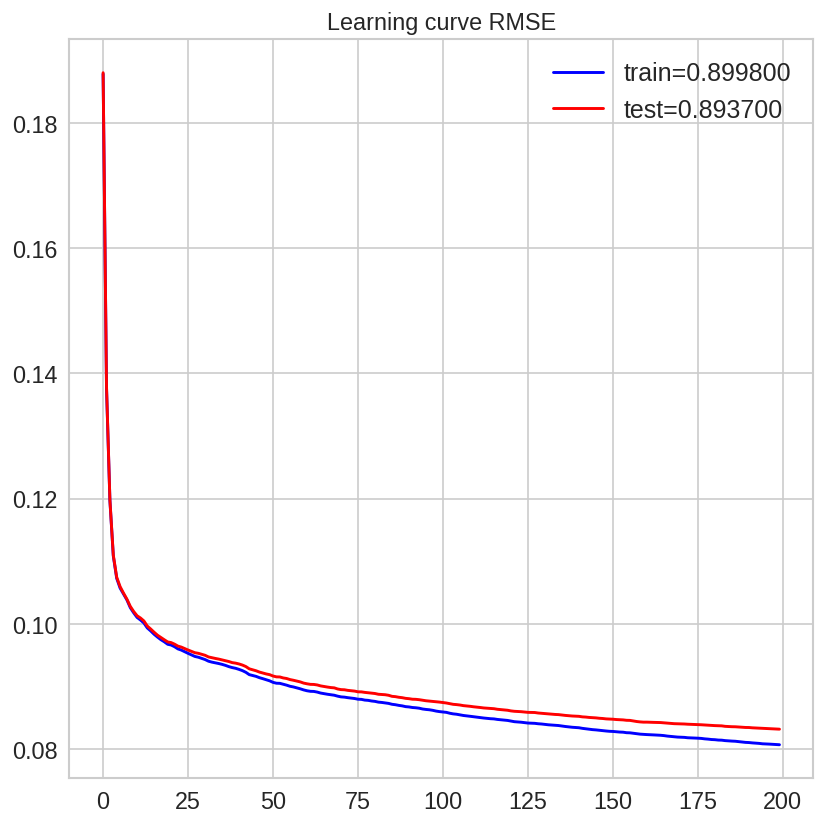

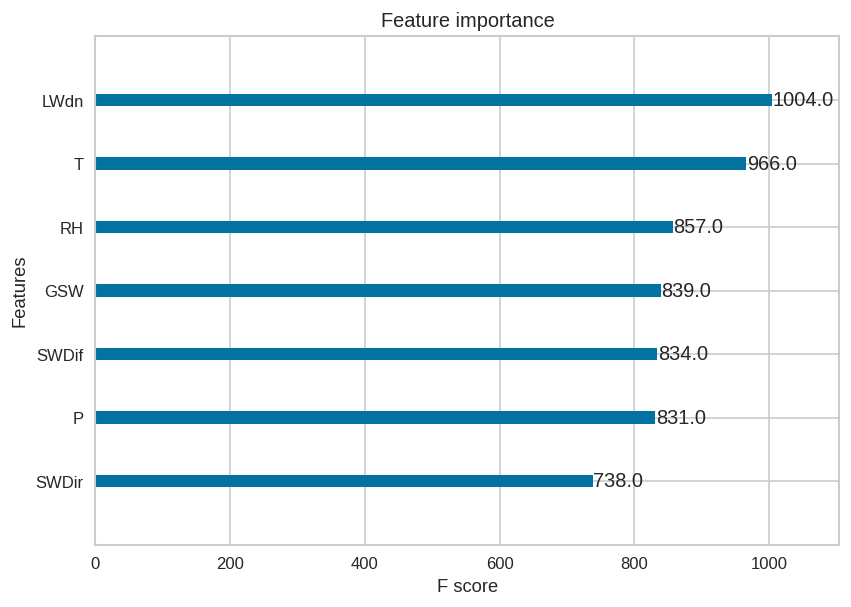

In [62]:
## Fitting model
evalSet = [(X_train, y_train), (X_test, y_test)]

# default model with experience values:
# Set initial parameters

default_model = XGBRegressor(
    learning_rate=0.5,
    n_estimators = 200,
    max_depth=5,
    min_child_weight=3,

    subsample=0.8,
    colsample_bytree=0.8,

    reg_alpha=0,
    reg_lambda=0,

    base_score=0.5, booster='gbtree', importance_type='gain',
    interaction_constraints='',
    # tree_method='exact', # CPU
    # tree_method='gpu_hist',
    device='cuda',
    validate_parameters=1, verbosity=None)

start_times = timer(None)


default_model.fit(X_train, cupy.array(y_train), eval_set=evalSet)

print(f'learning_rate=={default_model.learning_rate}')
print(f'model parameter=={default_model.get_params()}')

## Learning Curve plot with RMSE as a loos function
fig_name="default_model"
my_learning_curve(default_model, X_train, X_test, y_train, y_test,fig_name)
features_importace(default_model)

### Learning curve compared to the amount of data

This curve show us if we have enough data or not for the training

When we observe both curves, we show big gap between both curves and the validation curve (green curve) is still increasing. This mean that we have overfitting and we don't

have enough data for training the model. However, it doesn't mean that we are not able to fit the model with the data and apply tuning hyper parameters techniques.


### Feature importance

Before taking decision about feature engineering part, plotting Feature importance allow us to locate wich features are not important for the model. It can be use to reduce the data dimmensionality.

Generally: Feature Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model.


According to this results, all features are importante for the model to predict the target



### Tuning hyperparameters

By observing Learning curve, we see an overfitting. To solve this issue, we can apply hyper parameter optimizatin technique and feature engineering.

The following step show how to optimize the hyperparameter for XGBoost model.

The model XGBoost has many hyperparameters. In this project we focused on the hyperparameters tightly coupled with our issue.

* N estimators: number of tree

* Learning rate: step size shrinkage

* Max depth: maximum depth of a tree

* Subsample: Subsample ratio of the training instances

* Colsample bylevel: is the subsample ratio of columns for each level

* Colsample bytree: is the subsample ratio of columns when constructing each tree

* Colsample bynodes: is the subsample ratio of columns for each node (split)

* Min child weigth: the minimum sum of instance weight (hessian) needed in a child


# Optimisation method

In a talk by Owen at ODSC Boston 2015 titled Open Source Tools and Data Science Competitions, he summarized common parameters he uses :

* Number of Trees and Learning Rate: Fix the number of trees at around 100 (rather than 1000) and then tune the learning rate.

In our case we chosed n_estimators = 100



* The learning rate parameter can be set to control the weighting of new trees added to the model.

We can use the grid search capability in scikit-learn to evaluate the effect on logarithmic loss of training a gradient boosting model with different learning rate values.

N.B: Smaller learning rates generally require more trees to be added to the model and vice versa.

We chosed some standard learning rate values:

'learning_rate': [0.001, 0.005, 0.01, 0.05]  


## 1. learning rate and n_estimators

Let's assign different values for the "learning_rate" parameter : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3] and then plot the validation curve

In [ ]:
start_times = timer(None)

param_test1 = {
  'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3,],
  'n_estimators': [100, 200, 500, 1000]
}

evalSet = [(X_train, y_train), (X_test, y_test)]


gsearch_1 = GridSearchCV(estimator=default_model, param_grid=param_test1,
                         scoring='neg_root_mean_squared_error',
                         return_train_score=True,
                         n_jobs=-1, cv=10)

gsearch_1.fit(X_train, y_train)

gsearch_1.best_params_, gsearch_1.best_score_

timer(start_times)

# plot
plot_model_performance_heatmap(gsearch_1.cv_results_,
                               list(param_test1.keys())[0],
                               list(param_test1.keys())[1])
plot_overfitting_heatmap(gsearch_1.cv_results_, list(param_test1.keys())[0],
                               list(param_test1.keys())[1])

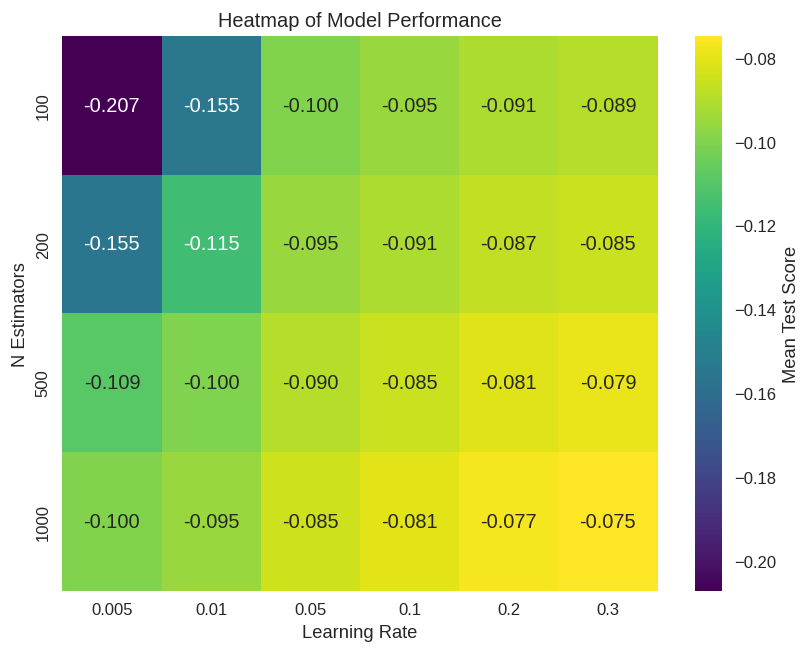

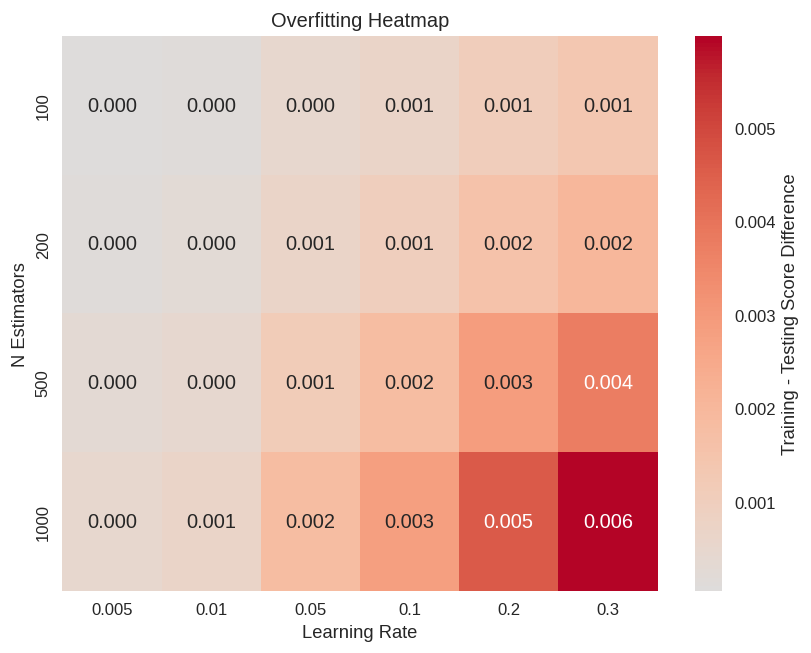

In [ ]:
plot_model_performance_heatmap(gsearch_1.cv_results_,
                               list(param_test1.keys())[0],
                               list(param_test1.keys())[1])
plot_overfitting_heatmap(gsearch_1.cv_results_, list(param_test1.keys())[0],
                               list(param_test1.keys())[1])

old learning_rate is: 0.5
new learning_rate is: 0.2
old n_estimators is: 200
new n_estimators is: 500
0.2
500
[0]	validation_0-rmse:0.25389	validation_1-rmse:0.25391
[1]	validation_0-rmse:0.21510	validation_1-rmse:0.21515
[2]	validation_0-rmse:0.18579	validation_1-rmse:0.18583
[3]	validation_0-rmse:0.16330	validation_1-rmse:0.16337
[4]	validation_0-rmse:0.14780	validation_1-rmse:0.14789
[5]	validation_0-rmse:0.13573	validation_1-rmse:0.13589
[6]	validation_0-rmse:0.12724	validation_1-rmse:0.12747
[7]	validation_0-rmse:0.12102	validation_1-rmse:0.12127
[8]	validation_0-rmse:0.11606	validation_1-rmse:0.11635
[9]	validation_0-rmse:0.11286	validation_1-rmse:0.11314
[10]	validation_0-rmse:0.11093	validation_1-rmse:0.11125
[11]	validation_0-rmse:0.10924	validation_1-rmse:0.10961
[12]	validation_0-rmse:0.10731	validation_1-rmse:0.10768
[13]	validation_0-rmse:0.10600	validation_1-rmse:0.10639
[14]	validation_0-rmse:0.10512	validation_1-rmse:0.10552
[15]	validation_0-rmse:0.10407	validation_1-r

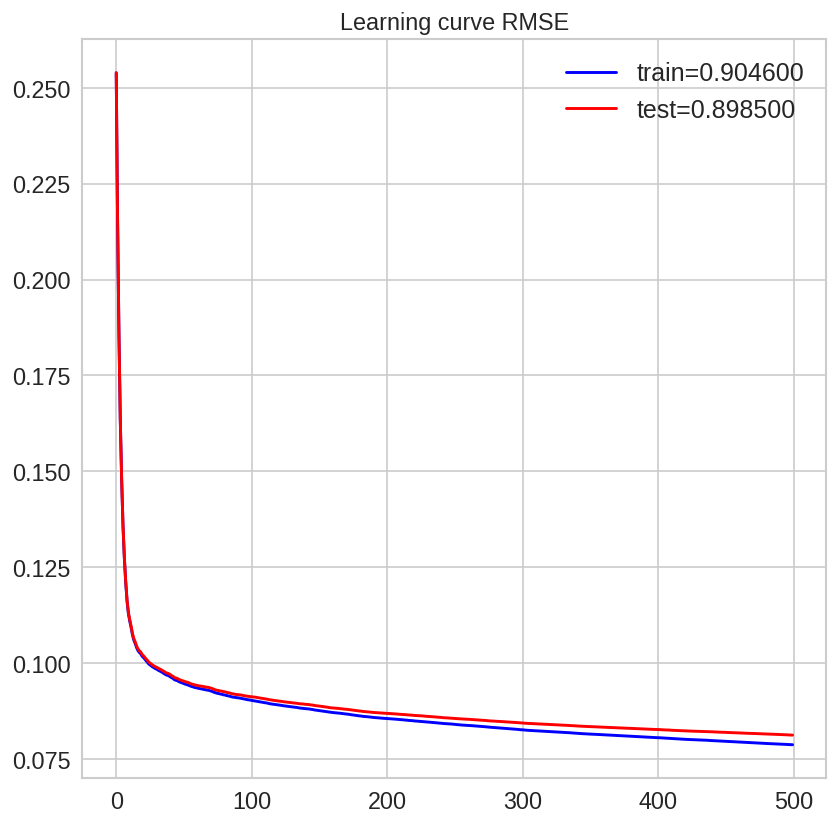

In [63]:
# upgrade model parameter:
upgrade_model(default_model, 'learning_rate', 0.2)
upgrade_model(default_model, 'n_estimators', 500)
print(default_model.get_params()['learning_rate'])
print(default_model.get_params()['n_estimators'])
default_model.fit(X_train, cupy.array(y_train), eval_set=evalSet)

my_learning_curve(default_model, X_train, X_test, y_train, y_test, fig_name)

## max_depth
This parameter allow us to control the size of decision trees.
- Shallow trees are expected to have poor performance because they capture few details of the problem and are generally referred to as weak learners.
- Deeper trees generally capture too many details of the problem and overfit the training dataset, limiting the ability to make good
predictions on new data.


In [ ]:
param_test1 = 'max_depth'
param_range = [2, 4, 6, 8, 10, 12]

single_param_search(default_model, param_test1, param_range)

old max_depth is: 5
new max_depth is: 10
[0]	validation_0-rmse:0.25142	validation_1-rmse:0.25162
[1]	validation_0-rmse:0.21048	validation_1-rmse:0.21090
[2]	validation_0-rmse:0.17863	validation_1-rmse:0.17940
[3]	validation_0-rmse:0.15352	validation_1-rmse:0.15457
[4]	validation_0-rmse:0.13572	validation_1-rmse:0.13700
[5]	validation_0-rmse:0.12207	validation_1-rmse:0.12359
[6]	validation_0-rmse:0.11226	validation_1-rmse:0.11406
[7]	validation_0-rmse:0.10491	validation_1-rmse:0.10690
[8]	validation_0-rmse:0.09870	validation_1-rmse:0.10091
[9]	validation_0-rmse:0.09465	validation_1-rmse:0.09700
[10]	validation_0-rmse:0.09176	validation_1-rmse:0.09432
[11]	validation_0-rmse:0.08961	validation_1-rmse:0.09236
[12]	validation_0-rmse:0.08697	validation_1-rmse:0.08990
[13]	validation_0-rmse:0.08511	validation_1-rmse:0.08818
[14]	validation_0-rmse:0.08392	validation_1-rmse:0.08714
[15]	validation_0-rmse:0.08254	validation_1-rmse:0.08588
[16]	validation_0-rmse:0.08126	validation_1-rmse:0.08476


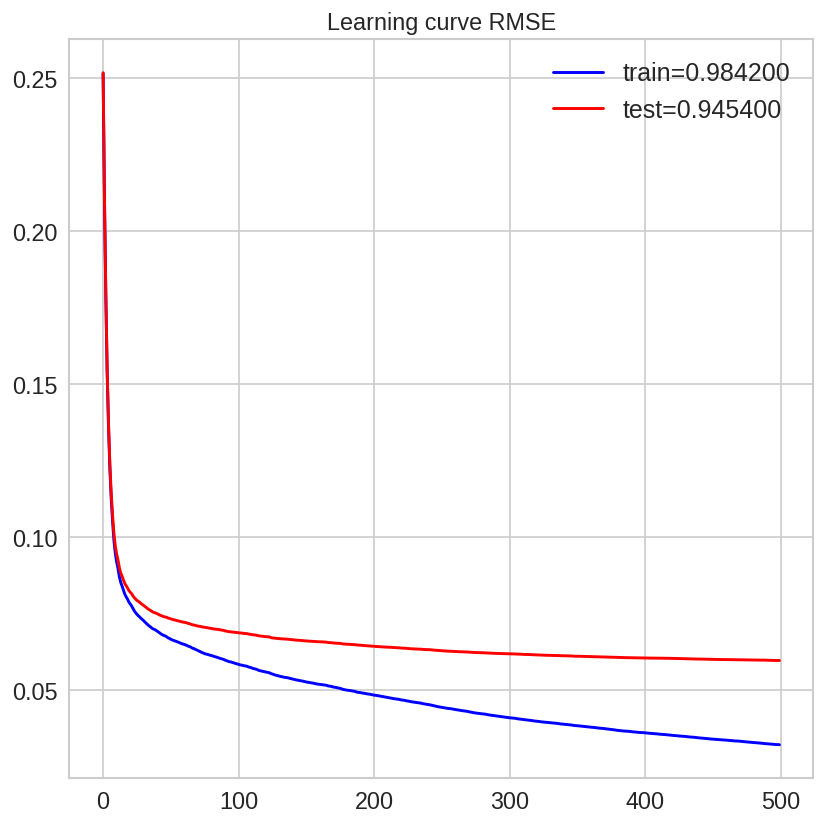

In [65]:
upgrade_model_and_plot(default_model, 'max_depth', 10)


## min_child_weight

In Gradient Boosting Decision Trees (GBDT), XGBoost uses both first-order gradients and second-order gradients to calculate the split gain at each node, where the second-order gradients help define the "weight sum" of a node.

The first-order gradient reflects the rate of change in loss for each sample, while the second-order gradient captures the curvature of the loss function.

min_child_weight threshold control the slope of the loss function. it allows only the slope (curvature) > than the min_child_weight.

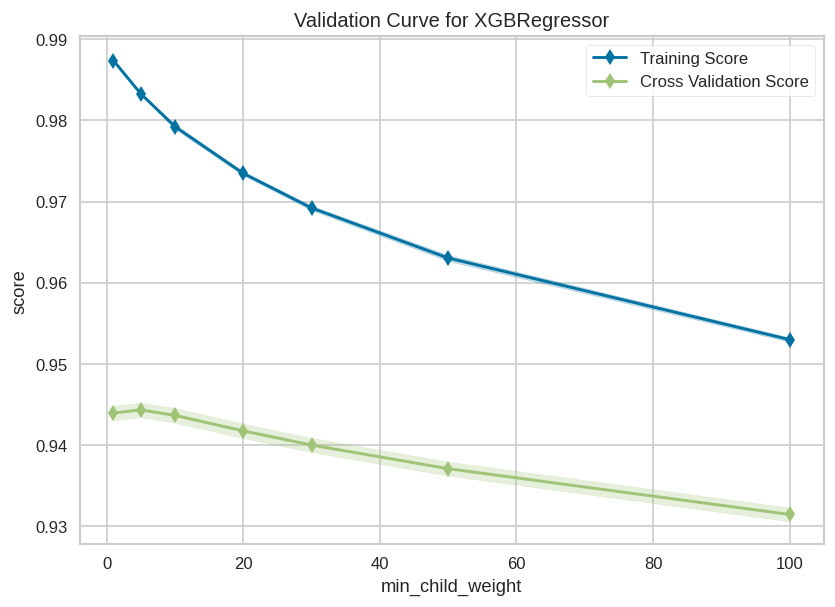

In [ ]:
param_test1 = 'min_child_weight'
param_range = [1, 5, 10, 20, 30, 50, 100]

single_param_search(default_model, param_test1, param_range)



old min_child_weight is: 3
new min_child_weight is: 50
[0]	validation_0-rmse:0.25157	validation_1-rmse:0.25173
[1]	validation_0-rmse:0.21079	validation_1-rmse:0.21116
[2]	validation_0-rmse:0.17920	validation_1-rmse:0.17980
[3]	validation_0-rmse:0.15429	validation_1-rmse:0.15511
[4]	validation_0-rmse:0.13668	validation_1-rmse:0.13770
[5]	validation_0-rmse:0.12327	validation_1-rmse:0.12449
[6]	validation_0-rmse:0.11366	validation_1-rmse:0.11503
[7]	validation_0-rmse:0.10650	validation_1-rmse:0.10799
[8]	validation_0-rmse:0.10044	validation_1-rmse:0.10214
[9]	validation_0-rmse:0.09656	validation_1-rmse:0.09832
[10]	validation_0-rmse:0.09384	validation_1-rmse:0.09575
[11]	validation_0-rmse:0.09184	validation_1-rmse:0.09389
[12]	validation_0-rmse:0.08947	validation_1-rmse:0.09164
[13]	validation_0-rmse:0.08776	validation_1-rmse:0.09002
[14]	validation_0-rmse:0.08667	validation_1-rmse:0.08901
[15]	validation_0-rmse:0.08547	validation_1-rmse:0.08794
[16]	validation_0-rmse:0.08441	validation_1

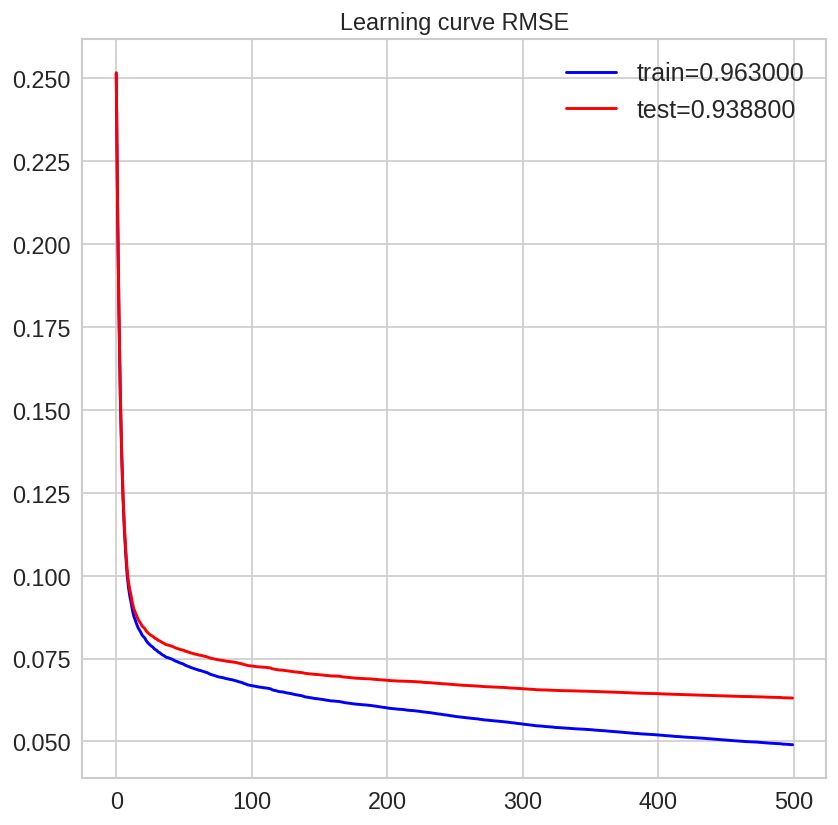

In [66]:
upgrade_model_and_plot(default_model, 'min_child_weight', 50)

## subsample
usually from 0.5 to 1.

This technique, known as data subsampling, is similar to the sample bagging used in random forests.

- Controls Overfitting:
    - When the subsample value is less than 1, each tree is trained on only a subset of the samples, increasing randomness in the training process and thereby reducing the risk of overfitting.
    - By preventing each tree from seeing the full data, subsample helps the model generalize better to new data.


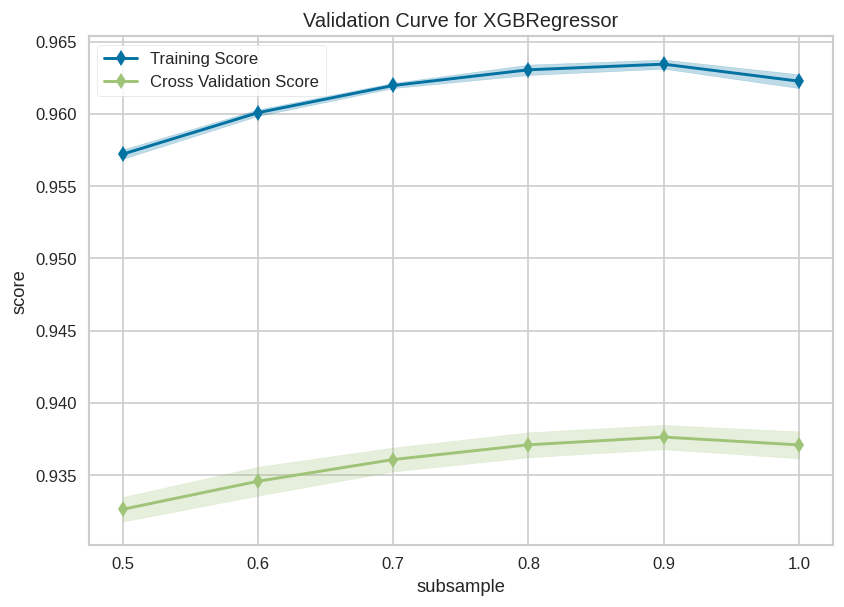

In [ ]:
param_test1 = 'subsample'
param_range = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

single_param_search(default_model, param_test1, param_range)


old subsample is: 0.8
new subsample is: 0.9
[0]	validation_0-rmse:0.25155	validation_1-rmse:0.25175
[1]	validation_0-rmse:0.21074	validation_1-rmse:0.21115
[2]	validation_0-rmse:0.17910	validation_1-rmse:0.17979
[3]	validation_0-rmse:0.15425	validation_1-rmse:0.15518
[4]	validation_0-rmse:0.13659	validation_1-rmse:0.13775
[5]	validation_0-rmse:0.12320	validation_1-rmse:0.12455
[6]	validation_0-rmse:0.11351	validation_1-rmse:0.11503
[7]	validation_0-rmse:0.10631	validation_1-rmse:0.10804
[8]	validation_0-rmse:0.10021	validation_1-rmse:0.10215
[9]	validation_0-rmse:0.09637	validation_1-rmse:0.09838
[10]	validation_0-rmse:0.09363	validation_1-rmse:0.09585
[11]	validation_0-rmse:0.09166	validation_1-rmse:0.09401
[12]	validation_0-rmse:0.08942	validation_1-rmse:0.09186
[13]	validation_0-rmse:0.08766	validation_1-rmse:0.09022
[14]	validation_0-rmse:0.08655	validation_1-rmse:0.08921
[15]	validation_0-rmse:0.08538	validation_1-rmse:0.08808
[16]	validation_0-rmse:0.08427	validation_1-rmse:0.087

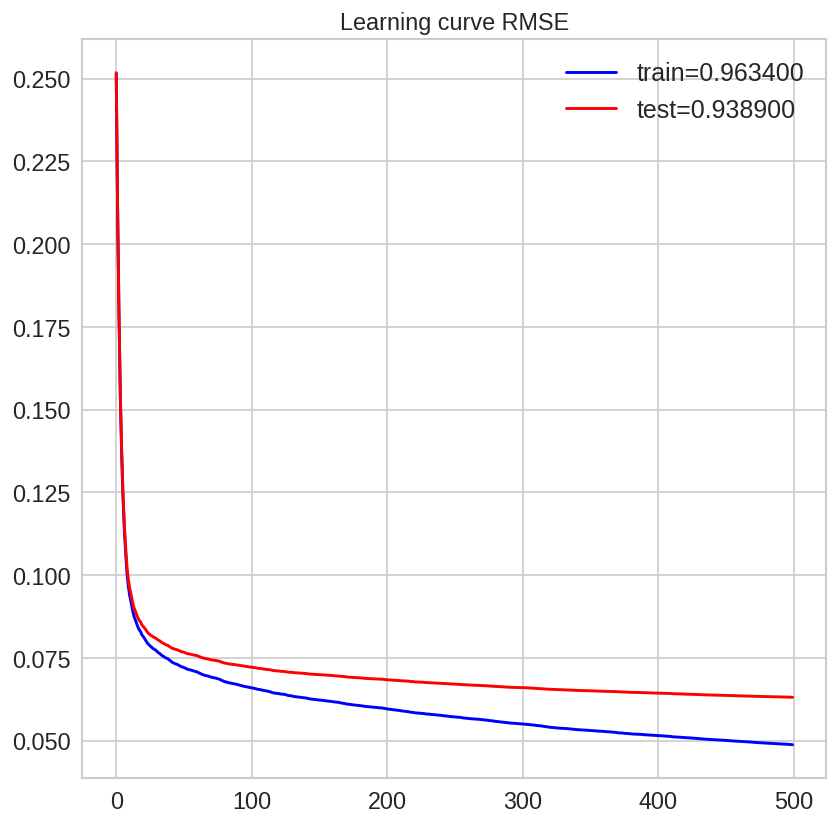

In [67]:
upgrade_model_and_plot(default_model, 'subsample', 0.9)

Reviewing the plot by the validation_curve function, we can see a marked jump from max depth=2 to max depth=12

then pretty even performance for the rest the values of max depth. Although the best score was

observed for max depth=12, it is interesting to note that there was practically little difference between using max depth=11 or max depth=13.

Here we fixe the value of max_depth = 12

##   colsample_bytree
colsample_bylevel', 'colsample_bynode'

For these 3 hyperparameter we can create a random sample of the features (or columns) to use prior to creating each

decision tree in the boosted model. The default value is 1.0 meaning that all columns are used in each decision tree.

We can evaluate values for colsample bytree between 0.1 and 1.0 incrementing by 0.1.

- Generally, tuning only colsample_bytree is sufficient in most cases. The other two parameters, colsample_bylevel and colsample_bynode, can be adjusted if additional control over feature sampling is needed, but they are typically left at their default values.

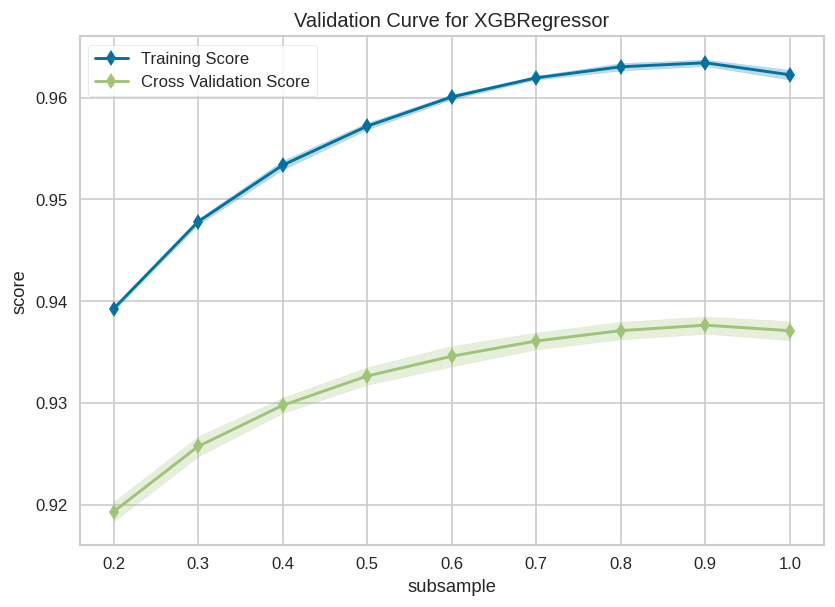

In [ ]:

hyper_param = 'colsample_bytree'
param_range = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1.0]
single_param_search(default_model, param_test1, param_range)

old colsample_bytree is: 10
new colsample_bytree is: 0.8
[0]	validation_0-rmse:0.25155	validation_1-rmse:0.25175
[1]	validation_0-rmse:0.21074	validation_1-rmse:0.21115
[2]	validation_0-rmse:0.17910	validation_1-rmse:0.17979
[3]	validation_0-rmse:0.15425	validation_1-rmse:0.15518
[4]	validation_0-rmse:0.13659	validation_1-rmse:0.13775
[5]	validation_0-rmse:0.12320	validation_1-rmse:0.12455
[6]	validation_0-rmse:0.11351	validation_1-rmse:0.11503
[7]	validation_0-rmse:0.10631	validation_1-rmse:0.10804
[8]	validation_0-rmse:0.10021	validation_1-rmse:0.10215
[9]	validation_0-rmse:0.09637	validation_1-rmse:0.09838
[10]	validation_0-rmse:0.09363	validation_1-rmse:0.09585
[11]	validation_0-rmse:0.09166	validation_1-rmse:0.09401
[12]	validation_0-rmse:0.08942	validation_1-rmse:0.09186
[13]	validation_0-rmse:0.08766	validation_1-rmse:0.09022
[14]	validation_0-rmse:0.08655	validation_1-rmse:0.08921
[15]	validation_0-rmse:0.08538	validation_1-rmse:0.08808
[16]	validation_0-rmse:0.08427	validation

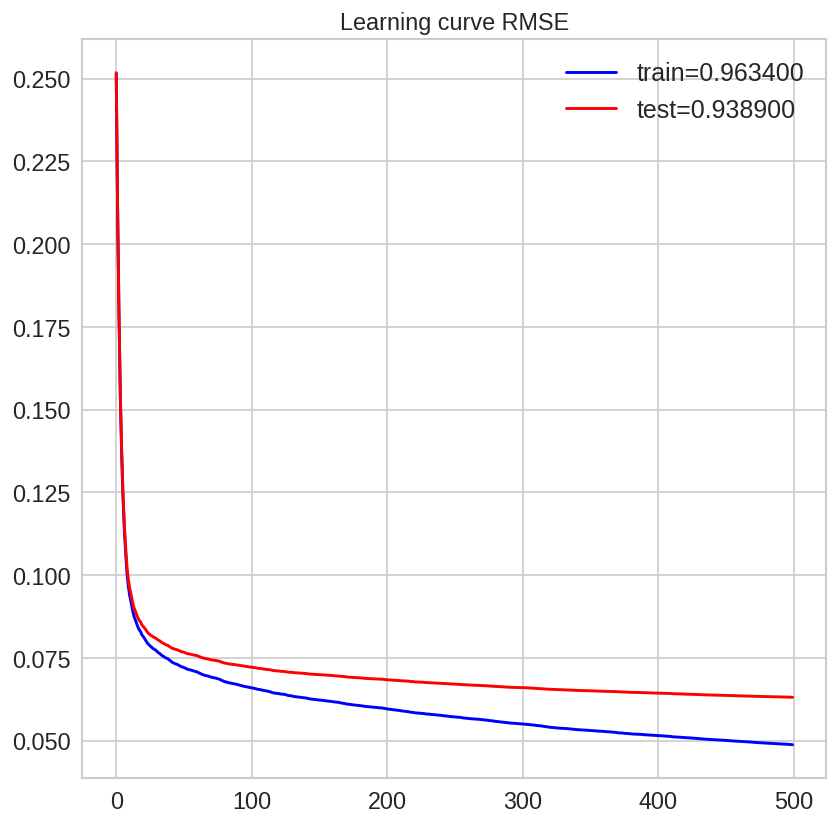

In [73]:
# upgrade model parameter:
upgrade_model_and_plot(default_model, 'colsample_bytree', 0.8)


## reg_alpha & reg_lambda

在 XGBoost 中，reg_alpha 和 reg_lambda 是正则化参数，用于控制模型的复杂性，防止过拟合。它们分别对应 L1 和 L2 正则化。以下是它们的详细解释及如何搜索最佳值：

1. reg_alpha（L1 正则化参数）
作用：reg_alpha 控制 L1 正则化的强度，也称为 Lasso 正则化。L1 正则化倾向于将不重要的特征权重缩小到零，这意味着它会产生稀疏的模型（有更多特征被删除）。
效果：适用于特征较多的数据集，因为它可以帮助去除不重要的特征，使模型更简洁。
调优建议：通常从较小的值开始测试，如 0、0.01、0.1、1、10，逐步增加，观察性能的变化。较大的 reg_alpha 值会对模型施加更强的惩罚，使得模型更加简单。
2. reg_lambda（L2 正则化参数）
作用：reg_lambda 控制 L2 正则化的强度，也称为 Ridge 正则化。L2 正则化会均匀地缩小所有特征的权重，但不会将它们缩小到零。它通常可以减少模型的方差，帮助模型更好地泛化。
效果：在特征较少或特征之间相关性较强的情况下，L2 正则化通常会更有效。
调优建议：可以从 0、0.1、1、10、100 等值开始测试。如果发现模型有过拟合趋势，可以尝试更大的 reg_lambda 值。

Function: reg_alpha controls the strength of L1 regularization, also known as Lasso regularization. L1 regularization tends to reduce the weights of unimportant features to zero, resulting in a sparse model (with more features being effectively removed).
Effect: Suitable for datasets with a large number of features, as it helps remove irrelevant features, making the model simpler and more efficient.
Tuning Suggestions: Typically, start with smaller values, such as 0, 0.01, 0.1, 1, and 10, and gradually increase to observe changes in performance. Higher reg_alpha values apply stronger penalties, leading to a simpler model.
reg_lambda (L2 Regularization Parameter)
Function: reg_lambda controls the strength of L2 regularization, also known as Ridge regularization. L2 regularization uniformly reduces the weights of all features but does not reduce them to zero. It generally helps to reduce the model's variance, enabling better generalization.
Effect: L2 regularization is typically more effective when there are fewer features or when the features are highly correlated.
Tuning Suggestions: Start with values like 0, 0.1, 1, 10, and 100. If the model shows signs of overfitting, consider testing higher reg_lambda values.

In [74]:
print(default_model.get_params()['reg_alpha'])

0


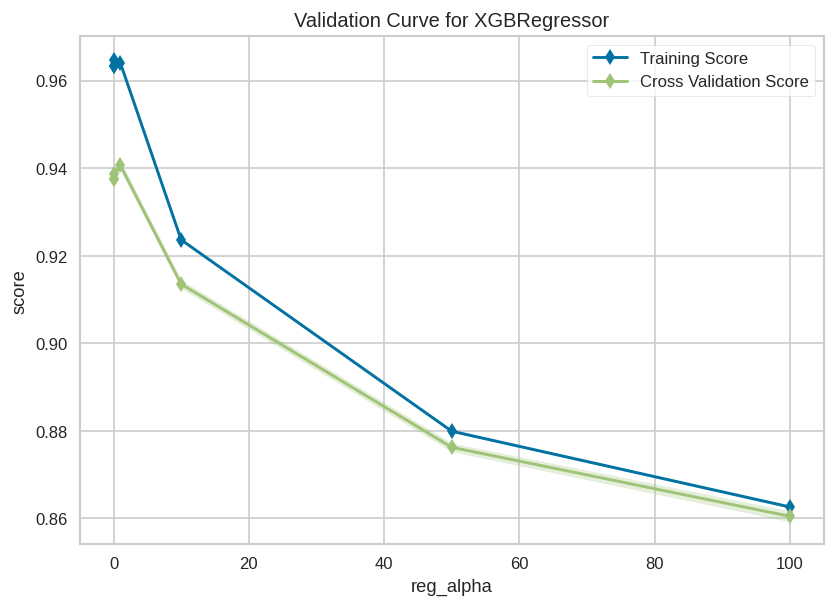

In [70]:
## reg_alpha

param_test1 = 'reg_alpha'
param_range = [0, 0.01, 0.1, 1, 10, 50, 100]
single_param_search(default_model, param_test1, param_range)


old reg_alpha is: 0
new reg_alpha is: 10
[0]	validation_0-rmse:0.25265	validation_1-rmse:0.25267
[1]	validation_0-rmse:0.21287	validation_1-rmse:0.21300
[2]	validation_0-rmse:0.18225	validation_1-rmse:0.18252
[3]	validation_0-rmse:0.15836	validation_1-rmse:0.15876
[4]	validation_0-rmse:0.14181	validation_1-rmse:0.14227
[5]	validation_0-rmse:0.12901	validation_1-rmse:0.12957
[6]	validation_0-rmse:0.11989	validation_1-rmse:0.12052
[7]	validation_0-rmse:0.11308	validation_1-rmse:0.11378
[8]	validation_0-rmse:0.10746	validation_1-rmse:0.10823
[9]	validation_0-rmse:0.10386	validation_1-rmse:0.10464
[10]	validation_0-rmse:0.10152	validation_1-rmse:0.10239
[11]	validation_0-rmse:0.09969	validation_1-rmse:0.10066
[12]	validation_0-rmse:0.09756	validation_1-rmse:0.09857
[13]	validation_0-rmse:0.09598	validation_1-rmse:0.09702
[14]	validation_0-rmse:0.09500	validation_1-rmse:0.09607
[15]	validation_0-rmse:0.09395	validation_1-rmse:0.09506
[16]	validation_0-rmse:0.09298	validation_1-rmse:0.09412


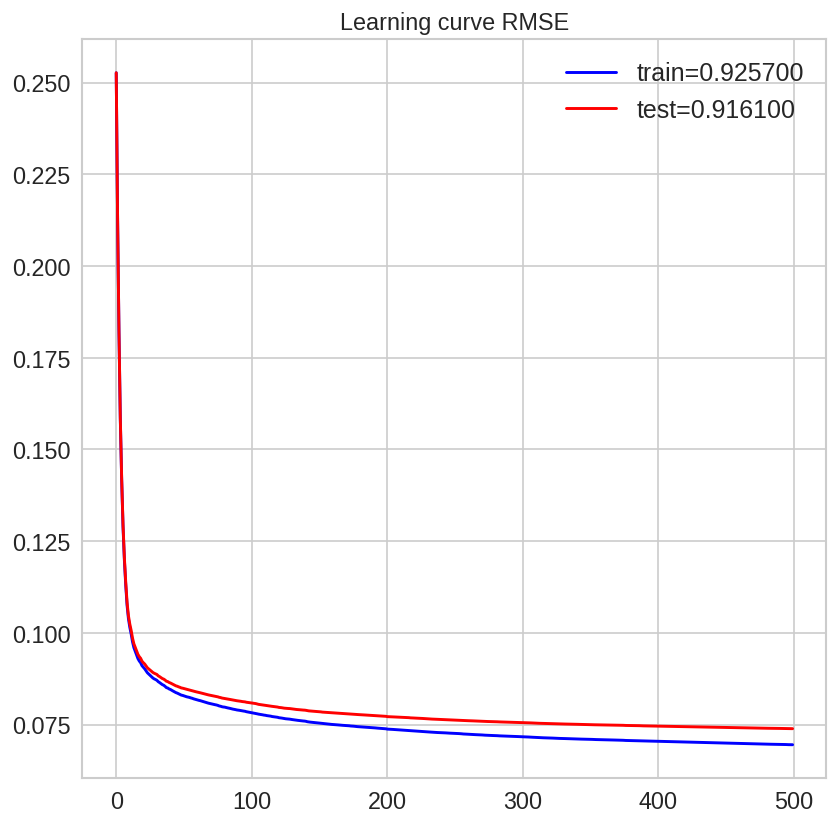

In [75]:
upgrade_model_and_plot(default_model, 'reg_alpha', 10)

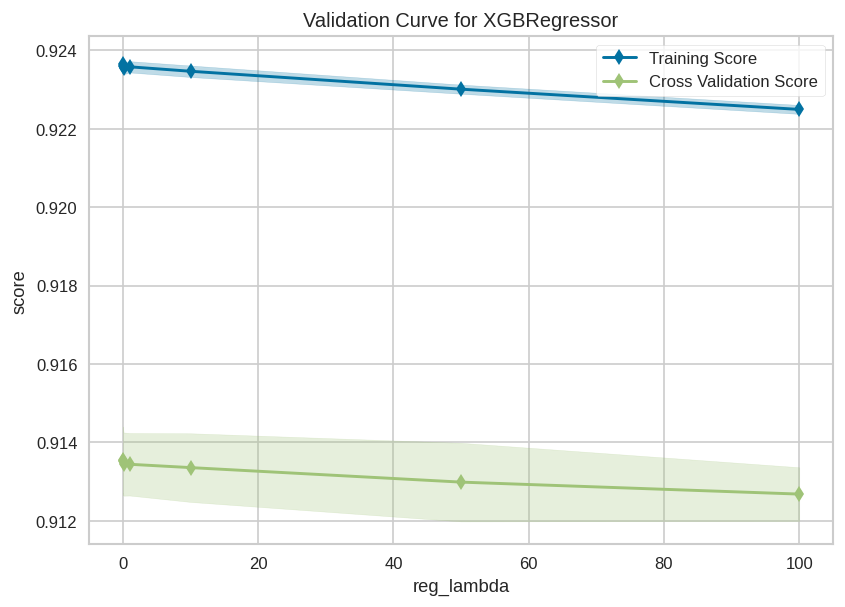

In [76]:
## reg_lambda

param_test1 = 'reg_lambda'
param_range = [0, 0.01, 0.1, 1, 10, 50, 100]
single_param_search(default_model, param_test1, param_range)

old reg_lambda is: 0
new reg_lambda is: 0
[0]	validation_0-rmse:0.25265	validation_1-rmse:0.25267
[1]	validation_0-rmse:0.21287	validation_1-rmse:0.21300
[2]	validation_0-rmse:0.18225	validation_1-rmse:0.18252
[3]	validation_0-rmse:0.15836	validation_1-rmse:0.15876
[4]	validation_0-rmse:0.14181	validation_1-rmse:0.14227
[5]	validation_0-rmse:0.12901	validation_1-rmse:0.12957
[6]	validation_0-rmse:0.11989	validation_1-rmse:0.12052
[7]	validation_0-rmse:0.11308	validation_1-rmse:0.11378
[8]	validation_0-rmse:0.10746	validation_1-rmse:0.10823
[9]	validation_0-rmse:0.10386	validation_1-rmse:0.10464
[10]	validation_0-rmse:0.10152	validation_1-rmse:0.10239
[11]	validation_0-rmse:0.09969	validation_1-rmse:0.10066
[12]	validation_0-rmse:0.09756	validation_1-rmse:0.09857
[13]	validation_0-rmse:0.09598	validation_1-rmse:0.09702
[14]	validation_0-rmse:0.09500	validation_1-rmse:0.09607
[15]	validation_0-rmse:0.09395	validation_1-rmse:0.09506
[16]	validation_0-rmse:0.09298	validation_1-rmse:0.09412

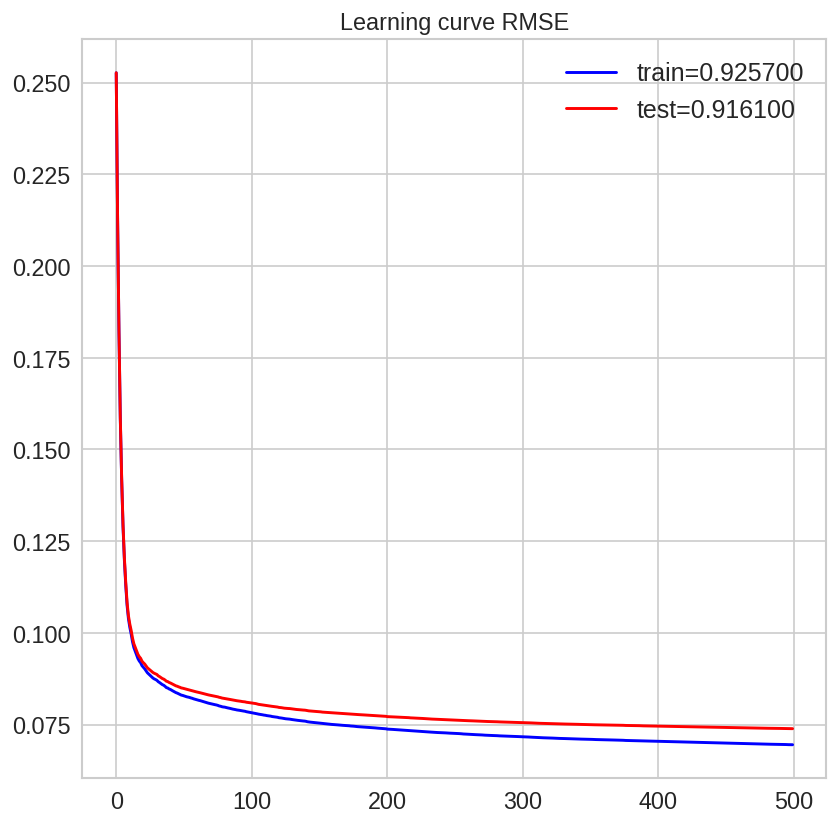

In [77]:
# upgrade model parameter:
upgrade_model_and_plot(default_model, 'reg_lambda', 0)

# best_estimator

In [78]:
print(default_model)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type='gain',
             interaction_constraints='', learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=50, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


## tuned_model:
save the model

- save the model
- load the model
- apply the model to test dataset
- save the test dataset

In [80]:
tuned_model = default_model

# save
import pickle
xgb_tuned = f'./xgb_tuned.mat'
pickle.dump(tuned_model, open(xgb_tuned, 'wb'))  # store the model trained



In [82]:
# load

import pickle
model_to_load = f'./xgb_tuned.mat'

tuned_model_load = pickle.load(open(model_to_load, 'rb'))

## plot with data set  test

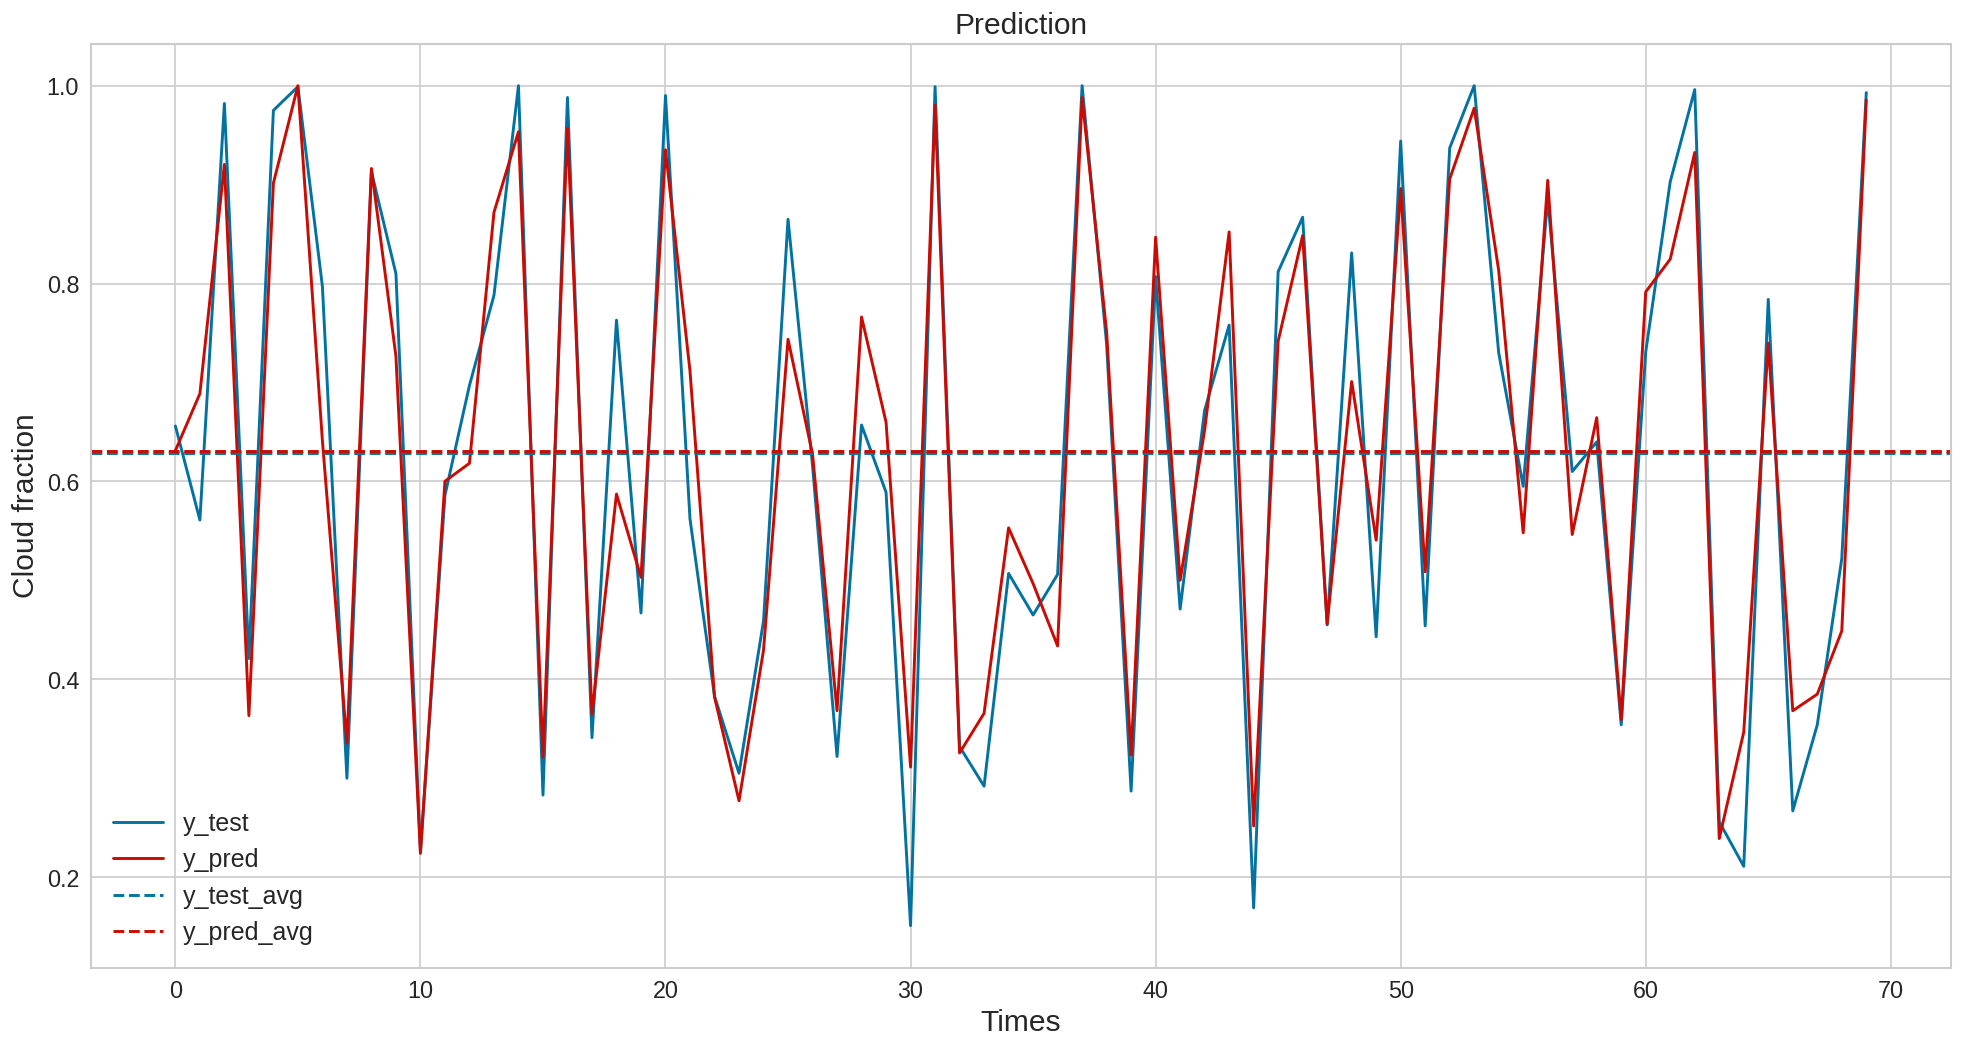

In [83]:
### Selection
start = 0
end = 70 # 8902
y_pred = prediction(X_test,tuned_model)

data_comp_resutl = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
CF_mean, Prediction_mean = prediction_CF(data_comp_resutl, 'y_pred', 'y_test',start,end, fig_name)